## Introduction

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Importing library in order to see the progress bar
from tqdm.notebook import tnrange, tqdm_notebook
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA

In [6]:
df = pd.read_csv('cleaned_twitter_data.csv')

In [7]:
df.shape

(1581247, 13)

In [8]:
df.tail(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
1581245,1,tinydiamondz,happy th birthday to my boo of alll time tup...,NaN,NaN,None,6,16,2009,8,40,49,Tuesday
1581246,1,RyanTrevMorris,happy,"thenspcc, sparkscharity, speakinguph4h",charitytuesday,None,6,16,2009,8,40,50,Tuesday


In [9]:
df.isna().sum()

Sentiment          0
User               0
Tweet              0
Tagging       854040
Hashtags     1546447
Emojis             0
Month              0
Day                0
Year               0
Hour               0
Minutes            0
Seconds            0
DayOfWeek          0
dtype: int64

In [10]:
df['Tagging'] = df['Tagging'].fillna('None')
df['Hashtags'] = df['Hashtags'].fillna('None')

In [11]:
df.isna().sum()

Sentiment    0
User         0
Tweet        0
Tagging      0
Hashtags     0
Emojis       0
Month        0
Day          0
Year         0
Hour         0
Minutes      0
Seconds      0
DayOfWeek    0
dtype: int64

In [12]:
df.shape

(1581247, 13)

### Taking a Sample data

In [13]:
# copying 5% of data
df_chunk = df.sample(frac=0.05).copy()

In [14]:
df_chunk.shape

(79062, 13)

In [15]:
df_chunk['Sentiment'].value_counts().sum()

79062

In [16]:
df_chunk['Sentiment'].value_counts()

0    39678
1    39384
Name: Sentiment, dtype: int64

In [17]:
df_chunk = df_chunk.reset_index(drop=True)

In [18]:
df_chunk.sample(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
52754,1,adychou,nighty night,that_kelly_girl,None,None,6,3,2009,3,14,30,Wednesday
9224,0,hernameisnicki,hates her ears they keep blocking up xx,None,None,None,6,17,2009,1,53,15,Wednesday


### working with sample data

In [28]:
# plt.figure(figsize=(10,4))
# df_chunk['Sentiment'].value_counts().plot(kind='bar', rot=0, color=['#FF7F0E', '#3685BC'])
# plt.title("Target Distirbution")
# plt.xlabel("Sentiment")
# plt.ylabel("Count")

# plt.show()

---
### Data Wrangling

In [19]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [20]:
df_chunk.head(2)

,Sentiment,User,Tweet,Tagging,Hashtags,Emojis,Month,Day,Year,Hour,Minutes,Seconds,DayOfWeek
0,1,lazygiraffe,did come back here to a folksy sale though hurrah,None,None,None,6,3,2009,6,8,17,Wednesday
1,1,gregzimmerman,yep i did a group shout out tweet so as not ...,michaelbeck,hhrs,None,5,29,2009,15,8,56,Friday


In [21]:
X = pd.DataFrame(df_chunk['Tweet']) # indep
y = df_chunk["Sentiment"] # dep

In [22]:
X.head()

,Tweet
0,did come back here to a folksy sale though hurrah
1,yep i did a group shout out tweet so as not ...
2,lol every does p seriously dudde i had a inte...
3,just finished curling her hair and now has to ...
4,my moms b day


#### Check the shape of the Data

In [23]:
X.shape

(79062, 1)

In [24]:
y.shape

(79062,)

In [25]:
# Test set 20 percent
X_rem, X_test, y_rem, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=1)

In [26]:
# Splitting the remainder in two chunks
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size = 0.3, stratify=y_rem, random_state=1)

In [27]:
print(f'Shape of X-test set: {X_test.shape}')
print(f'Shape of X remainder set: {X_rem.shape}')

print(f'Shape of validation set: {X_val.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of X-test set: (15813, 1)
Shape of X remainder set: (63249, 1)
Shape of validation set: (18975, 1)
Shape of train set: (44274, 1)


Our final proportions end up being
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

In [38]:
bagofwords_vector = CountVectorizer(stop_words="english")

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [39]:
X_train_transform

<44274x35057 sparse matrix of type '<class 'numpy.int64'>'
	with 275686 stored elements in Compressed Sparse Row format>

In [40]:
len(bagofwords_vector.get_feature_names_out())

35057

In [41]:
np.mean(X_train_transform.toarray().sum(axis=0))


8.037139515645949

Based on the mean we try min_df of ~8

In [42]:
bagofwords_vector = CountVectorizer(stop_words="english", min_df=8)

bagofwords_vector.fit(X_train['Tweet'])

X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [43]:
X_train_transform

<44274x3883 sparse matrix of type '<class 'numpy.int64'>'
	with 224123 stored elements in Compressed Sparse Row format>

In [44]:
len(bagofwords_vector.get_feature_names_out())

3883

In [45]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
my_df = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
display(my_df)

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yuck,yucky,yum,yummy,yup,zach,zealand,zero,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
my_df.shape[0] == X_train.shape[0]

True

In [47]:
# pip install nltk

### Vectorisation using Count Vectorizer model

In [32]:
import nltk
from nltk.stem import WordNetLemmatizer

# Let's test it out
# stemmer = nltk.stem.PorterStemmer()

In [49]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [50]:
lemmatizer = WordNetLemmatizer()

bagofwords_vector = CountVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer.lemmatize(i) for i in x.split()], min_df=8)
# 2. Fit
bagofwords_vector.fit(X_train['Tweet'])

CountVectorizer(min_df=8, stop_words='english',
                tokenizer=<function <lambda> at 0x7f5d3332d510>)

In [51]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_transform = bagofwords_vector.transform(X_train['Tweet'])
X_val_transform = bagofwords_vector.transform(X_val['Tweet'])
X_test_transform = bagofwords_vector.transform(X_test['Tweet'])

In [52]:
X_train_transform

<44274x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 235260 stored elements in Compressed Sparse Row format>

In [53]:
X_val_transform

<18975x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 100528 stored elements in Compressed Sparse Row format>

In [54]:
X_test_transform

<15813x3712 sparse matrix of type '<class 'numpy.int64'>'
	with 82409 stored elements in Compressed Sparse Row format>

15813 features to 4668 feature

In [55]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_train_transform.toarray())
X_train_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_val_transform.toarray())
X_val_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_vect = pd.DataFrame(columns=bagofwords_vector.get_feature_names_out(), data=X_test_transform.toarray())
X_test_df_vect

,aaah,aaron,ab,ability,able,absolute,absolutely,abt,ac,accent,...,yum,yummy,yup,z,zach,zealand,zero,zombie,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15810,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
words = bagofwords_vector.get_feature_names_out()
some_indices = range(1, 3708, round(3708/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaron', 'boyle', 'cure', 'fault', 'hehehe', 'level', 'nz', 'really', 'sorted', 'trouble']


In [59]:
counts = np.array(X_train_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaron,boyle,cure,fault,hehehe,level,nz,really,sorted,trouble
total_corpus_count,11,17,13,22,28,27,12,1339,11,45


In [60]:
bagofwords_vector.get_feature_names_out()

array(['aaah', 'aaron', 'ab', ..., 'zombie', 'zone', 'zoo'], dtype=object)

In [61]:
word_counts = pd.DataFrame(
    {"counts": X_train_transform.toarray().sum(axis=0)},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("counts", ascending=False)

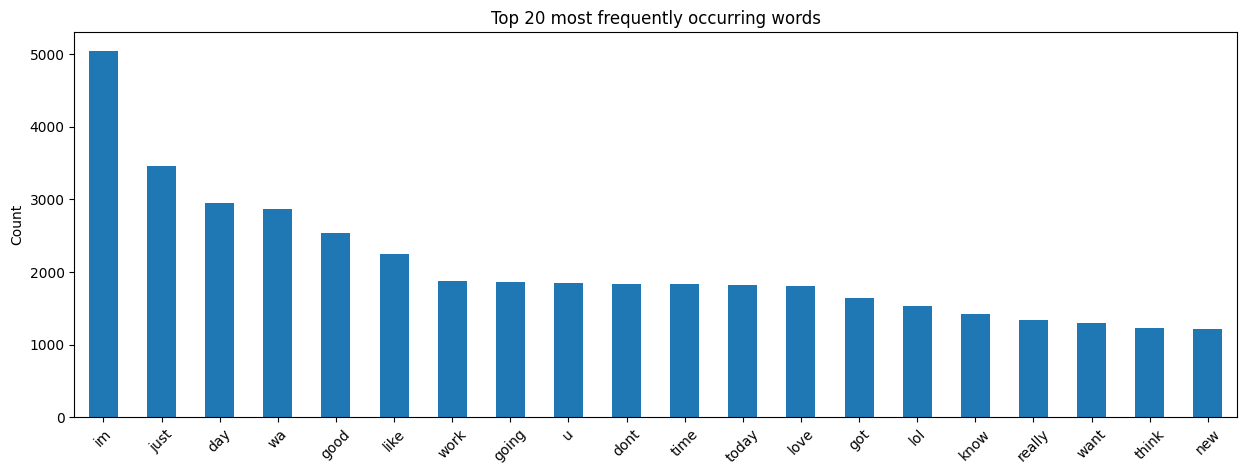

In [62]:
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Vectorisation using TF-IDF model

In [63]:
lemmatizer_tfidf = WordNetLemmatizer()

tfidf_vector = TfidfVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer_tfidf.lemmatize(i) for i in x.split()], min_df=3)
# 2. Fit
tfidf_vector.fit(X_train['Tweet'])

TfidfVectorizer(min_df=3, stop_words='english',
                tokenizer=<function <lambda> at 0x7f5d27486290>)

In [64]:
# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_tfidf_transform = tfidf_vector.transform(X_train['Tweet'])
X_val_tfidf_transform = tfidf_vector.transform(X_val['Tweet'])
X_test_tfidf_transform = tfidf_vector.transform(X_test['Tweet'])

In [65]:
X_train_tfidf_transform

<44274x8115 sparse matrix of type '<class 'numpy.float64'>'
	with 254270 stored elements in Compressed Sparse Row format>

In [66]:
X_val_tfidf_transform

<18975x8115 sparse matrix of type '<class 'numpy.float64'>'
	with 107791 stored elements in Compressed Sparse Row format>

In [67]:
X_test_tfidf_transform

<15813x8115 sparse matrix of type '<class 'numpy.float64'>'
	with 88337 stored elements in Compressed Sparse Row format>

In [68]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_train_tfidf_transform.toarray())
X_train_df_tfidf_vect

,aa,aaaah,aaah,aaand,aaaww,aah,aahh,aaron,aaww,ab,...,zoe,zoey,zombie,zomg,zone,zoo,zoom,zune,zzz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_val_tfidf_transform.toarray())
X_val_df_tfidf_vect

,aa,aaaah,aaah,aaand,aaaww,aah,aahh,aaron,aaww,ab,...,zoe,zoey,zombie,zomg,zone,zoo,zoom,zune,zzz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_test_tfidf_transform.toarray())
X_test_df_tfidf_vect

,aa,aaaah,aaah,aaand,aaaww,aah,aahh,aaron,aaww,ab,...,zoe,zoey,zombie,zomg,zone,zoo,zoom,zune,zzz,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#sanity check - to make sure the shape are equal
X_train_tfidf_transform.shape[0] == X_train.shape[0]

True

In [72]:
#Checking the shape of the summary dataframe
print(f'There are {X_train_tfidf_transform.shape[0]} rows, and {X_train_tfidf_transform.shape[1]} columns in the X_train summary dataframe')

There are 44274 rows, and 8115 columns in the X_train summary dataframe


In [73]:
words = tfidf_vector.get_feature_names_out()
some_indices = range(1, 8023, round(8023/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaaah', 'bound', 'cuddle', 'fame', 'hehehe', 'lemme', 'nominated', 'quit', 'slut', 'took', 'yayyyy']


In [74]:
counts = np.array(X_train_tfidf_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaaah,bound,cuddle,fame,hehehe,lemme,nominated,quit,slut,took,yayyyy
total_corpus_count,2.308619,4.361872,13.311774,2.58601,13.702288,4.438069,1.67548,9.409739,2.671652,57.244573,2.721656


### Modeling

In [31]:
from sklearn.linear_model import LogisticRegression

In [76]:
# Initializing Scale
scaler = RobustScaler()

# Fitting scale
scaler.fit(X_train_df_vect)

# Transform scale
X_train_scaled = scaler.transform(X_train_df_vect)
X_validation_scaled = scaler.transform(X_val_df_vect)
X_test_scaled = scaler.transform(X_test_df_vect)

In [77]:
# instantiate model
logreg_model = LogisticRegression(max_iter=10000, random_state=1)

# fit the model
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000, random_state=1)

In [78]:
# Training and test score
print(f"Train score: {logreg_model.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg_model.score(X_validation_scaled, y_val)}")

Train score: 0.7875502552288025
Validation score: 0.7383399209486166


In [79]:
logreg_model.coef_[0]

array([ 0.45188   ,  0.22334205, -0.40392828, ...,  0.308317  ,
        0.01513186,  0.81680151])

In [80]:
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model.coef_[0]},
    index=bagofwords_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

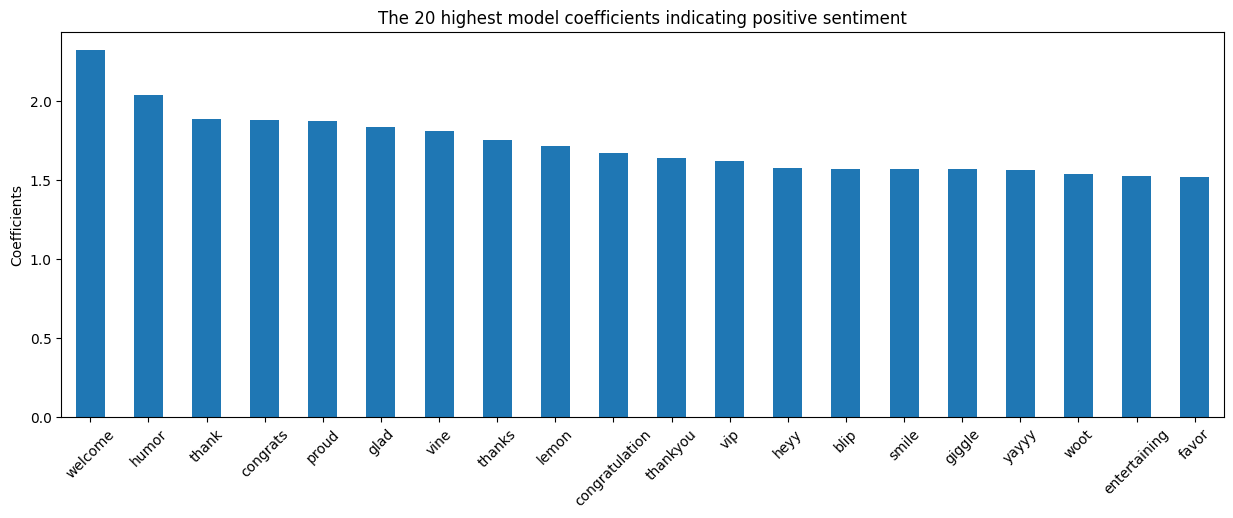

In [81]:
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

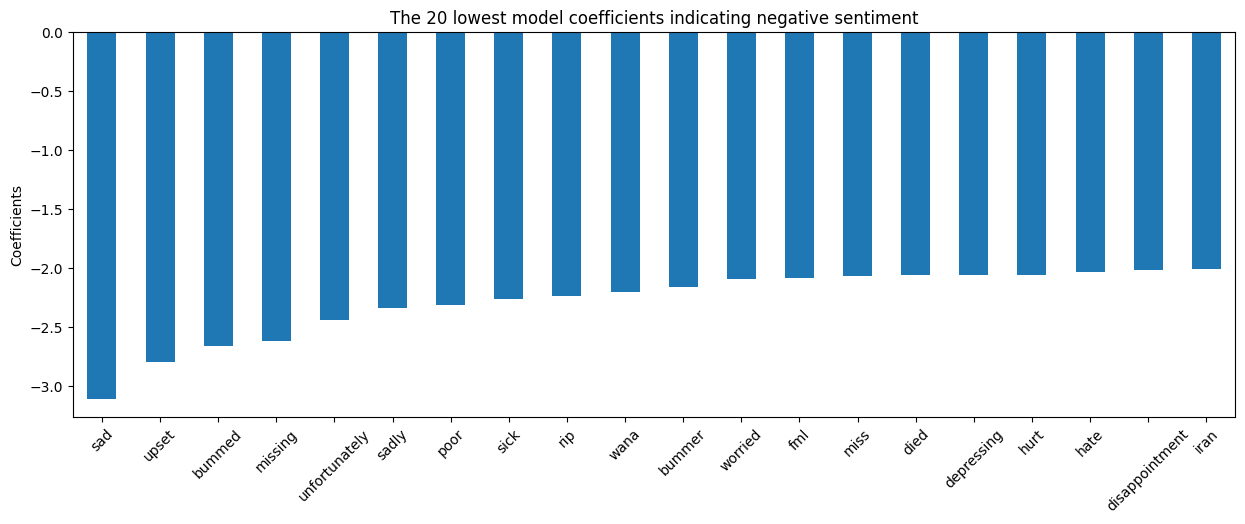

In [82]:
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [83]:
word_coefficients

,coefficients
welcome,2.320944
humor,2.035565
thank,1.885933
congrats,1.875807
proud,1.868805
...,...
unfortunately,-2.442365
missing,-2.618228
bummed,-2.656653
upset,-2.793926


In [84]:
# instantiate model
logreg = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# fit the model
logreg.fit(X_train_scaled, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7875502552288025
Validation score: 0.7383399209486166


In [85]:
%%time
# instantiate model
logreg = LogisticRegression(C=0.5, penalty='l2', solver='liblinear', max_iter=10000, random_state=1)# saga different regularization and try out

# fit the model
logreg.fit(X_train_scaled, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_scaled, y_train)}")
print(f"Validation score: {logreg.score(X_validation_scaled, y_val)}")

Train score: 0.7848624474861092
Validation score: 0.7410276679841897
CPU times: user 3.1 s, sys: 1.57 s, total: 4.67 s
Wall time: 1.3 s


---
### Logistic Regression on TF-IDF Vectorizer

In [86]:
# Initializing Scale
scaler_tfidf = RobustScaler()

# Fitting scale
scaler_tfidf.fit(X_train_df_tfidf_vect)

# Transform scale
X_train_tfidf_scaled = scaler_tfidf.transform(X_train_df_tfidf_vect)
X_validation_tfidf_scaled = scaler_tfidf.transform(X_val_df_tfidf_vect)
X_test_tfidf_scaled = scaler_tfidf.transform(X_test_df_tfidf_vect)

In [91]:
# instantiate model
logreg_model_tfidf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# fit the model
logreg_model_tfidf.fit(X_train_tfidf_scaled, y_train)
# Training and test score
print(f"Train score: {logreg_model_tfidf.score(X_train_tfidf_scaled, y_train)}")
print(f"Validation score: {logreg_model_tfidf.score(X_validation_tfidf_scaled, y_val)}")

Train score: 0.8002213488729277
Validation score: 0.7477206851119894


In [92]:
word_coefficients = pd.DataFrame(
    {"coefficients": logreg_model_tfidf.coef_[0]},
    index=tfidf_vector.get_feature_names_out()
).sort_values("coefficients", ascending=False)

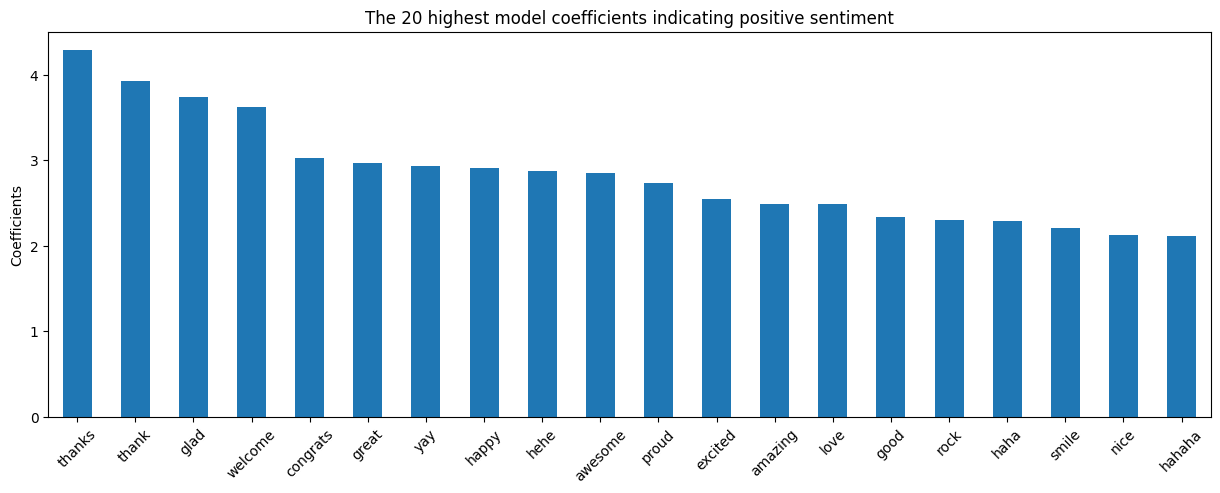

In [93]:
word_coefficients.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

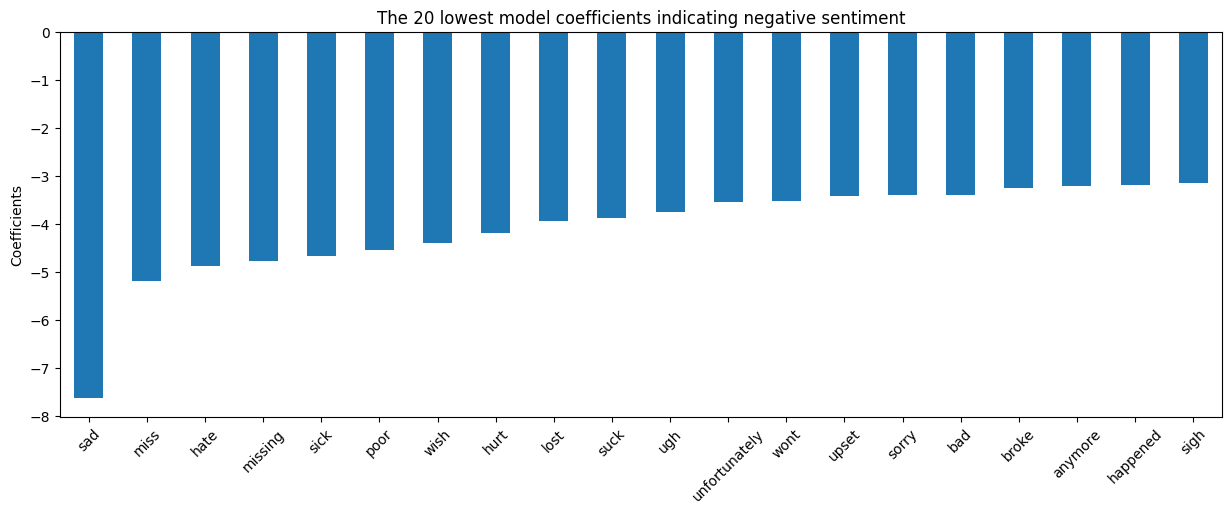

In [94]:
word_coefficients.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix for the LogisticRegression

In [29]:
#Import the confusion matrix libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Importing the classification report library
from sklearn.metrics import classification_report

In [30]:
# Importing precision and recall score libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [97]:
# Get class predictions
y_pred = logreg.predict(X_test_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5633,2304
True Positive,1732,6144


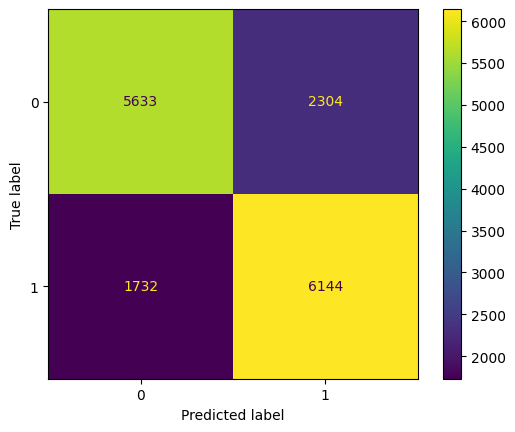

In [98]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test)

In [99]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.71      0.74      7937
           1       0.73      0.78      0.75      7876

    accuracy                           0.74     15813
   macro avg       0.75      0.74      0.74     15813
weighted avg       0.75      0.74      0.74     15813



In [100]:
# Make probabilistic predictions (scores)
y_proba = logreg.predict_proba(X_test_scaled)[:,1]

In [101]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7272727272727273
Recall score: 0.7800914169629254

Threshold of 0.2:
Precision score: 0.5922834645669292
Recall score: 0.9550533265617065


---
### Logistic Regression on TF-IDF Vectorizer

In [102]:
# Get class predictions
y_pred = logreg_model_tfidf.predict(X_test_tfidf_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5781,2156
True Positive,1777,6099


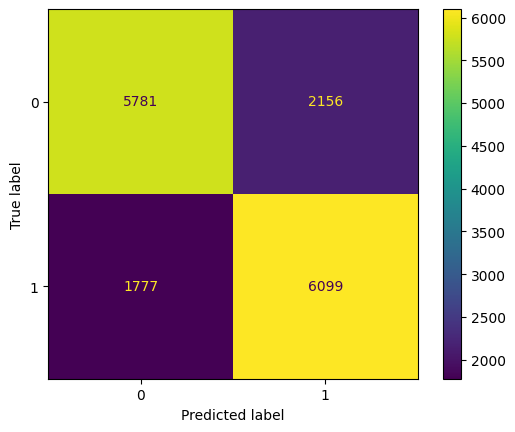

In [103]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model_tfidf, X_test_tfidf_scaled, y_test)

In [104]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      7937
           1       0.74      0.77      0.76      7876

    accuracy                           0.75     15813
   macro avg       0.75      0.75      0.75     15813
weighted avg       0.75      0.75      0.75     15813



In [105]:
# Make probabilistic predictions (scores)
y_proba = logreg_model_tfidf.predict_proba(X_test_tfidf_scaled)[:,1]

In [106]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.738824954572986
Recall score: 0.7743778567800914

Threshold of 0.2:
Precision score: 0.5863979073703647
Recall score: 0.9677501269680041


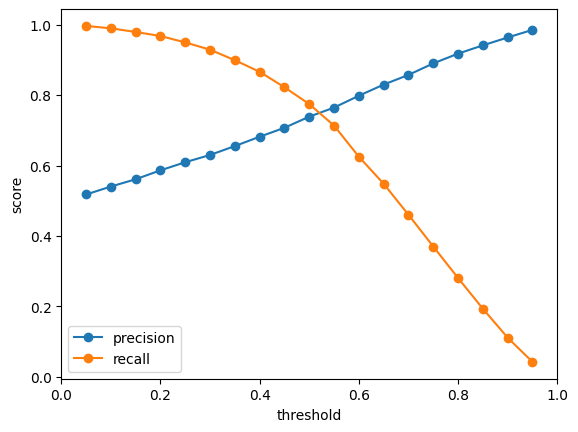

In [107]:
from sklearn.metrics import accuracy_score

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba > threshold, 1, 0)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)
    
    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

### Including n-grams

In [33]:
lemmatizer_tfidf = WordNetLemmatizer()

tfidf_vector = TfidfVectorizer(stop_words="english",
                                    tokenizer=lambda x: [lemmatizer_tfidf.lemmatize(i) for i in x.split()], min_df=3, max_features=5000, ngram_range=(1, 3))
# 2. Fit
tfidf_vector.fit(X_train['Tweet'])

# 3. Transform - tokenize (split to words) & count for each sentence how many times each occurs
X_train_tfidf_transform = tfidf_vector.transform(X_train['Tweet'])
X_val_tfidf_transform = tfidf_vector.transform(X_val['Tweet'])
X_test_tfidf_transform = tfidf_vector.transform(X_test['Tweet'])

In [34]:
X_train_tfidf_transform

<44274x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 263423 stored elements in Compressed Sparse Row format>

In [35]:
X_val_tfidf_transform

<18975x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 110674 stored elements in Compressed Sparse Row format>

In [36]:
X_test_tfidf_transform

<15813x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 91779 stored elements in Compressed Sparse Row format>

In [37]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_train_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_train_tfidf_transform.toarray())
X_train_df_tfidf_vect

,aah,aaron,ab,abc,able,absolutely,abt,abuse,ac,accent,...,yu,yuck,yum,yummy,yung,yup,z,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_val_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_val_tfidf_transform.toarray())
X_val_df_tfidf_vect

,aah,aaron,ab,abc,able,absolutely,abt,abuse,ac,accent,...,yu,yuck,yum,yummy,yung,yup,z,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# We can extract the information and put it in a data frame to make it easier to see what has occured
X_test_df_tfidf_vect = pd.DataFrame(columns=tfidf_vector.get_feature_names_out(), data=X_test_tfidf_transform.toarray())
X_test_df_tfidf_vect

,aah,aaron,ab,abc,able,absolutely,abt,abuse,ac,accent,...,yu,yuck,yum,yummy,yung,yup,z,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#sanity check - to make sure the shape are equal
X_train_tfidf_transform.shape[0] == X_train.shape[0]

True

In [41]:
#Checking the shape of the summary dataframe
print(f'There are {X_train_tfidf_transform.shape[0]} rows, and {X_train_tfidf_transform.shape[1]} columns in the X_train summary dataframe')

There are 44274 rows, and 5000 columns in the X_train summary dataframe


In [42]:
words = tfidf_vector.get_feature_names_out()
some_indices = range(1, 5000, round(5000/10))
samples = [words[i] for i in some_indices]
print(samples)

['aaron', 'bye bye', 'doesnt like', 'gmail', 'ill tell', 'like little', 'nite nite', 'regent', 'stranger', 'u want']


In [43]:
counts = np.array(X_train_tfidf_transform[:, some_indices].sum(axis = 0))

display(pd.DataFrame({"total_corpus_count": counts[0]}, index=samples).T)

,aaron,bye bye,doesnt like,gmail,ill tell,like little,nite nite,regent,stranger,u want
total_corpus_count,4.222823,9.33001,6.932322,5.337896,6.384768,3.687688,4.272008,5.674998,4.68514,7.439511


### Logistic Regression TF-IDF vectorizer after including n-grams

In [44]:
# Initializing Scale
scaler_tfidf = RobustScaler()

# Fitting scale
scaler_tfidf.fit(X_train_df_tfidf_vect)

# Transform scale
X_train_tfidf_scaled = scaler_tfidf.transform(X_train_df_tfidf_vect)
X_validation_tfidf_scaled = scaler_tfidf.transform(X_val_df_tfidf_vect)
X_test_tfidf_scaled = scaler_tfidf.transform(X_test_df_tfidf_vect)

In [47]:
# instantiate model
logreg_model_tfidf = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1)

# fit the model
logreg_model_tfidf.fit(X_train_tfidf_scaled, y_train)

# Training and test score
print(f"Train score: {logreg_model_tfidf.score(X_train_tfidf_scaled, y_train)}")
print(f"Validation score: {logreg_model_tfidf.score(X_validation_tfidf_scaled, y_val)}")

Train score: 0.7940777883182003
Validation score: 0.7491436100131752


In [48]:
# Get class predictions
y_pred = logreg_model_tfidf.predict(X_test_tfidf_scaled)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Negative", "Predicted Positive"],
    index=["True Negative", "True Positive"]
)

display(cf_df)

,Predicted Negative,Predicted Positive
True Negative,5730,2206
True Positive,1748,6129


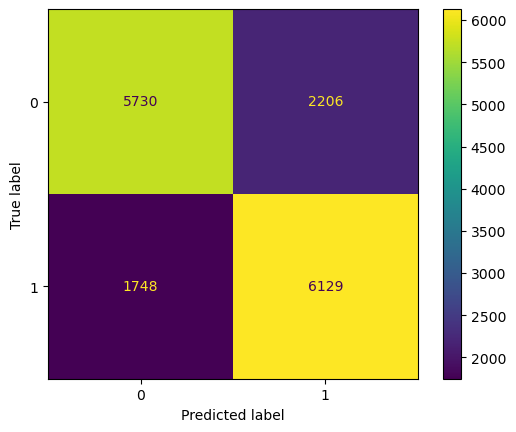

In [49]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logreg_model_tfidf, X_test_tfidf_scaled, y_test)

In [50]:
#Now the classification report can be generated
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      7936
           1       0.74      0.78      0.76      7877

    accuracy                           0.75     15813
   macro avg       0.75      0.75      0.75     15813
weighted avg       0.75      0.75      0.75     15813



In [51]:
# Make probabilistic predictions (scores)
y_proba = logreg_model_tfidf.predict_proba(X_test_tfidf_scaled)[:,1]

In [52]:
# First calculate precision and recall using the default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)
print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
print("")

# Calculate the same using a much lower cut-off (0.2)
y_threshold = np.where(y_proba > 0.2, 1, 0)
print("Threshold of 0.2:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.7353329334133173
Recall score: 0.7780881046083534

Threshold of 0.2:
Precision score: 0.5840165504559037
Recall score: 0.9676272692649486


### Saving file

In [53]:
X_train_df_tfidf_vect.to_csv('train_vectorized.csv', index=False)
X_val_df_tfidf_vect.to_csv('validation_vectorized.csv', index=False)
X_test_df_tfidf_vect.to_csv('test_vectorized.csv', index=False)

In [54]:
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
y_val.to_csv('y_val.csv', index=False)

In [55]:
#sanity check
check_df = pd.read_csv('train_vectorized.csv')
check_df

,aah,aaron,ab,abc,able,absolutely,abt,abuse,ac,accent,...,yu,yuck,yum,yummy,yung,yup,z,zombie,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
